# Use Google API to find various stores in Davidson County

In [1]:
import requests
import json
import time
import pickle
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
# import censusdata
import pandas as pd
import math
from sklearn.metrics.pairwise import haversine_distances
%matplotlib inline

## The Google `nearbysearch` api endpoint returns locations of various `types` within a `radius` centered on a lat/lng coordinate `location`
## We can use this to find locations that may be relevant to identifying food deserts

Google API key is stored in a separate file for security

In [2]:
with open('keys.pkl', 'rb') as keys_file:
    api_keys = pickle.load(keys_file)
    api_key = api_keys['google'] #api key is generated through the google cloud platform

Set default values to use for testing and later use

In [3]:
location = '36.1612, -86.7775' # lat, lng as a string
radius = '32200' # in meters, 20 miles, approximate distance from Davidson center to furthest edge
types = 'grocery_or_supermarket' # select single store type as a test case

In [4]:
all_types = ['bakery',
             'convenience_store',
             'department_store',
             'drugstore',
             'gas_station',
             'grocery_or_supermarket',
             'home_goods_store',
             'supermarket',
             'pharmacy']
# additional types are 'store' and 'shopping_mall'

This is the function that will do the heavy lifting of preparing and making the request

In [5]:
# Modified from https://python.gotrained.com/google-places-api-extracting-location-data-reviews/

def search_places_by_coordinate(location, radius, types, api_key, sleep_sec = 2):
    endpoint_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    places = []
    params = {
        'location': location,
        'radius': radius,
        'types': types,
        'key': api_key
    }
    res = requests.get(endpoint_url, params = params)
    results =  json.loads(res.content)
    places.extend(results['results'])
    time.sleep(sleep_sec)
    while "next_page_token" in results:
        params['pagetoken'] = results['next_page_token'],
        res = requests.get(endpoint_url, params = params)
        results = json.loads(res.content)
        places.extend(results['results'])
        time.sleep(sleep_sec)
    return places

Test the api request using just `grocery_or_supermarket` and encompassing whole county

In [6]:
grocery_stores_20_mi_radius = search_places_by_coordinate(location, radius, types, api_key)

Check the response

In [7]:
len(grocery_stores_20_mi_radius)

60

In [8]:
grocery_stores_20_mi_radius[0]['geometry']['location']

{'lat': 36.1031403, 'lng': -86.8187272}

In [9]:
nash_map = folium.Map([36.1612, -86.7775])
for store in grocery_stores_20_mi_radius:
    coords = store['geometry']['location']
    lat = coords['lat']
    lng = coords['lng']
    folium.Marker([lat, lng]).add_to(nash_map)
nash_map

Expand to multiple store types

In [10]:
multiple_stores_20_mi_radius = search_places_by_coordinate(location, radius, all_types, api_key)

In [11]:
# Still only 60 stores, turns out it is a return limit of the endpoint
len(multiple_stores_20_mi_radius)

60

## Since endpoint only return up to 60 locations per request, will make multiple requests across the county

#### Start out by making a grid over the county

In [12]:
# File retrieved from data.nashville.gov
davidson_county = gpd.read_file('data/Davidson County Border (GIS).geojson')
davidson_county.crs = "EPSG:4326"

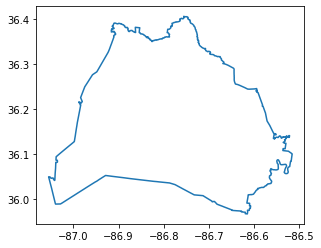

In [13]:
davidson_county.boundary.plot();

Find total geographic bounds of davidson county

In [14]:
xmin,ymin,xmax,ymax =  davidson_county.total_bounds

Divide total bounds into 10x10 grid

In [15]:
x_increment = (xmax-xmin)/10
y_increment = (ymax-ymin)/10

In [16]:
# determine boundary locations along x-axis
grid_x_boundaries = [xmin]
new_bound = xmin
for i in range(10):
    new_bound = new_bound + x_increment
    grid_x_boundaries.append(new_bound)

In [17]:
# determine boundary locations along y-axis
grid_y_boundaries = [ymin]
new_bound = ymin
for i in range(10):
    new_bound = new_bound + y_increment
    grid_y_boundaries.append(new_bound)

In [18]:
# get lats and lons in separate lists for center of each grid square
lons = []
lats = []
for left, right in zip(grid_x_boundaries[:-1], grid_x_boundaries[1:]):
    for top, bottom in zip(grid_y_boundaries[:-1], grid_y_boundaries[1:]):
        lats.append((top+bottom)/2)
        lons.append((left+right)/2)
    

In [19]:
# convery to gpd points
grid_centers = gpd.points_from_xy(lons, lats)

In [20]:
# put into geodataframe
grid_gdf = gpd.GeoDataFrame(geometry = grid_centers, crs = "EPSG:4326")

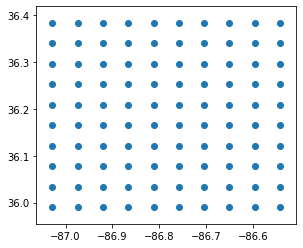

In [21]:
grid_gdf.plot()

We'll get more into this in a bit, but we need to add a buffer around the county to include stores slightly outside (1 mile). These stores could influence the existance of food deserts

Geopandas buffers are calculated based on the crs of the gdf. Since we are usine "EPSG:4326" we know the units are degrees. Using this conversion from the USGS (https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps?qt-news_science_products=0#qt-news_science_products): "One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet." We can approximate the number of degrees in a mile as: 1/69 = 0.014492753623188406

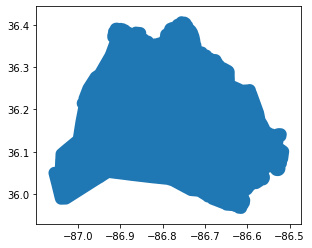

In [79]:
davidson_county_buffer = gpd.GeoDataFrame(geometry = davidson_county['geometry'].buffer(0.014492753623188406),
                                          crs = "EPSG:4326")
davidson_county_buffer.plot()

In [81]:
# Only keep points within the buffered Davidson county polygon
keep_points = []
for ind, p in grid_gdf['geometry'].iteritems():
    if p.within(davidson_county_buffer.loc[0, 'geometry']) or p.within(davidson_county_buffer.loc[1, 'geometry']):
        keep_points.append(ind)

grid_points_sub = grid_gdf.loc[keep_points]

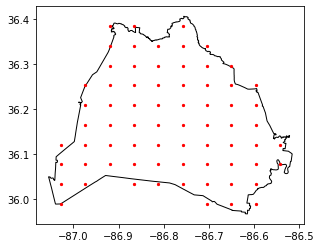

In [82]:
base = davidson_county.plot(color='white', edgecolor='black')

grid_points_sub.plot(ax=base, marker='o', color='red', markersize=5);

## Now with grid points laid out across county iterate over full list of types and points to get more store

Since looking at smaller areas, adjust radius. Since points are based on lat and lng now, need to calculate distance differently. Distance in meters from lat, lng coordinates is best calculated using the `haversine distance` formula

In [75]:
# function adapted from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
def dist_in_meters(point_1, point_2):
    point_1 = [math.radians(l) for l in [point_1.y, point_1.x]]
    point_2 = [math.radians(l) for l in [point_2.y, point_2.x]]
    dist_array_m = haversine_distances([point_1, point_2])*6371000
    return dist_array_m[0][1]

In [76]:
grid_point_radius = dist_in_meters(grid_points_sub.loc[1, 'geometry'], grid_points_sub.loc[2, 'geometry'])

Check to make sure the entire county is covered

''

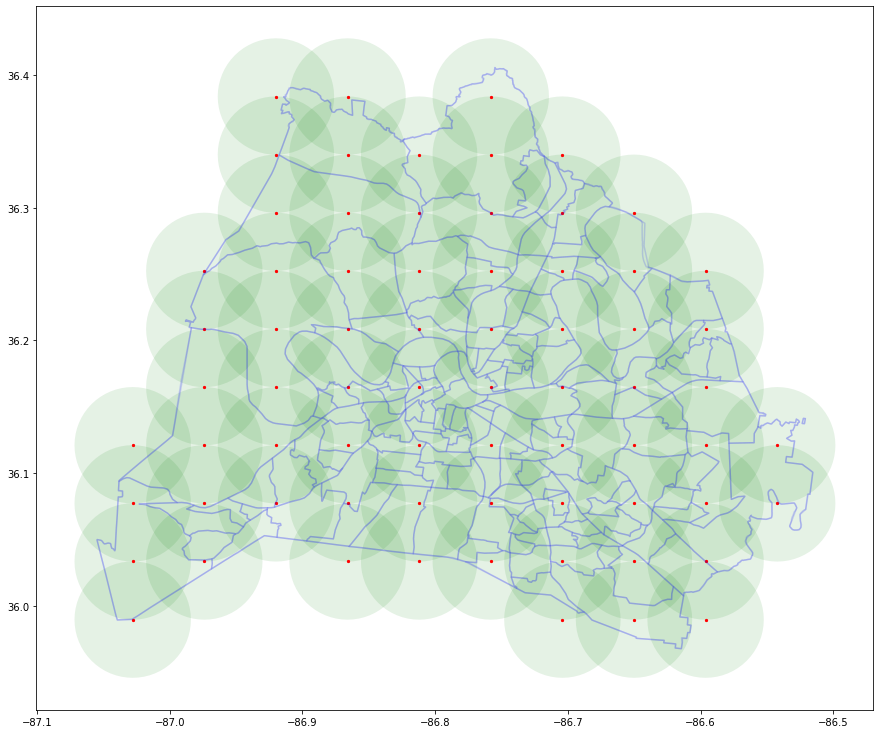

In [83]:
grid_point_radius_mile = 3.0258050367212114828/69
grid_points_sub_buffers = gpd.GeoDataFrame(geometry = grid_points_sub['geometry'].buffer(grid_point_radius_mile),
                                          crs = "EPSG:4326")
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.boundary.plot(ax=ax, edgecolor = 'blue', color='blue', alpha = 0.15)
ax = davidson_county.boundary.plot(ax=ax, color='blue', alpha = 0.15)
ax = grid_points_sub_buffers.plot(ax=ax, color = 'green', alpha = 0.1)
grid_points_sub.plot(ax=ax, marker='o', color='red', markersize=5)
;

It covers all of the county

In [26]:
# creating output list in separate cell in case need to run for loop multiple times because of time out errors
responses = []

#### This one can take a while, run with caution

In [27]:
for ind_2, t in enumerate(all_types):
    print(ind_2, t) # just to keep track of progress
    # if ind_2 >= 1: # uncomment and tab below over if need to start later in all_types list
    for ind, (lng, lat) in enumerate(list(zip(grid_points_sub['geometry'].x, grid_points_sub['geometry'].y))): # note that lat and lng are switched
        # print(ind, lat, lng) # again, to keep track of progress
        # if ind >= 0: # uncomment and tab below if need to start later in grid df
        location = '{}, {}'.format(lat, lng)
        responses.append(search_places_by_coordinate(location, grid_point_radius, t, api_key, sleep_sec = 10))

0 bakery
0 36.0334511183116 -87.02786810545533
1 36.07724413412592 -87.02786810545533
2 36.0334511183116 -86.97391335478568
3 36.07724413412592 -86.97391335478568
4 36.12103714994022 -86.97391335478568
5 36.16483016575454 -86.97391335478568
6 36.20862318156884 -86.97391335478568
7 36.07724413412592 -86.919958604116
8 36.12103714994022 -86.919958604116
9 36.16483016575454 -86.919958604116
10 36.20862318156884 -86.919958604116
11 36.252416197383155 -86.919958604116
12 36.29620921319746 -86.919958604116
13 36.07724413412592 -86.86600385344636
14 36.12103714994022 -86.86600385344636
15 36.16483016575454 -86.86600385344636
16 36.20862318156884 -86.86600385344636
17 36.252416197383155 -86.86600385344636
18 36.29620921319746 -86.86600385344636
19 36.34000222901177 -86.86600385344636
20 36.07724413412592 -86.81204910277668
21 36.12103714994022 -86.81204910277668
22 36.16483016575454 -86.81204910277668
23 36.20862318156884 -86.81204910277668
24 36.252416197383155 -86.81204910277668
25 36.296209

38 36.12103714994022 -86.70413960143736
39 36.16483016575454 -86.70413960143736
40 36.20862318156884 -86.70413960143736
41 36.252416197383155 -86.70413960143736
42 36.29620921319746 -86.70413960143736
43 35.9896581024973 -86.65018485076772
44 36.0334511183116 -86.65018485076772
45 36.07724413412592 -86.65018485076772
46 36.12103714994022 -86.65018485076772
47 36.16483016575454 -86.65018485076772
48 36.20862318156884 -86.65018485076772
49 36.252416197383155 -86.65018485076772
50 36.0334511183116 -86.59623010009804
51 36.07724413412592 -86.59623010009804
52 36.12103714994022 -86.59623010009804
53 36.16483016575454 -86.59623010009804
54 36.20862318156884 -86.59623010009804
55 36.12103714994022 -86.5422753494284
4 gas_station
0 36.0334511183116 -87.02786810545533
1 36.07724413412592 -87.02786810545533
2 36.0334511183116 -86.97391335478568
3 36.07724413412592 -86.97391335478568
4 36.12103714994022 -86.97391335478568
5 36.16483016575454 -86.97391335478568
6 36.20862318156884 -86.973913354785

20 36.07724413412592 -86.81204910277668
21 36.12103714994022 -86.81204910277668
22 36.16483016575454 -86.81204910277668
23 36.20862318156884 -86.81204910277668
24 36.252416197383155 -86.81204910277668
25 36.29620921319746 -86.81204910277668
26 36.34000222901177 -86.81204910277668
27 36.0334511183116 -86.75809435210704
28 36.07724413412592 -86.75809435210704
29 36.12103714994022 -86.75809435210704
30 36.16483016575454 -86.75809435210704
31 36.20862318156884 -86.75809435210704
32 36.252416197383155 -86.75809435210704
33 36.29620921319746 -86.75809435210704
34 36.34000222901177 -86.75809435210704
35 36.383795244826075 -86.75809435210704
36 36.0334511183116 -86.70413960143736
37 36.07724413412592 -86.70413960143736
38 36.12103714994022 -86.70413960143736
39 36.16483016575454 -86.70413960143736
40 36.20862318156884 -86.70413960143736
41 36.252416197383155 -86.70413960143736
42 36.29620921319746 -86.70413960143736
43 35.9896581024973 -86.65018485076772
44 36.0334511183116 -86.65018485076772


In [28]:
# total number of requests
len(responses)

504

`responses` contains list of list of locations. Flatten to get single list of locations

In [30]:
responses_flat = [i for l in responses for i in l]

In [31]:
# total number of stores across all requests
len(responses_flat)

7349

There is probably a better way to do this but use the following steps to find unique stores:
- find unique `place_id`
- iterate through unique ids and flattened responses for first instance of id

In [32]:
unique_store_id = set([i['place_id'] for i in responses_flat])

In [33]:
unique_grocery_store = []
for i in unique_store_id:
    for store in responses_flat:
        if store['place_id'] == i:
            unique_grocery_store.append(store)
            break

In [34]:
# number of unique ids
len(unique_grocery_store)

2618

Extract lat and lng from store locations and put in dataframe

In [35]:
lats = []
lons = []
for store in unique_grocery_store:
    lats.append(store['geometry']['location']['lat'])
    lons.append(store['geometry']['location']['lng'])
all_store_locations = gpd.points_from_xy(lons, lats)
all_store_gdf = gpd.GeoDataFrame(geometry = all_store_locations, crs = "EPSG:4326")

keep only stores within buffered Davidson County polygon

In [84]:
keep_stores = []
for ind, p in all_store_gdf['geometry'].iteritems():
    if p.within(davidson_county_buffer.loc[0, 'geometry']) or p.within(davidson_county_buffer.loc[1, 'geometry']):
        keep_stores.append(ind)

davidson_store_gdf = all_store_gdf.loc[keep_stores]

In [85]:
# number of stores in Davidson County
len(davidson_store_gdf)

2535

Plot locations on folium map

In [38]:
nash_map = folium.Map([36.1612, -86.7775])
for ind, store in davidson_store_gdf.iterrows():
    lng = store['geometry'].x
    lat = store['geometry'].y
    folium.Marker([lat, lng]).add_to(nash_map)
nash_map

And again just using geopandas to see points in context of store locations within county

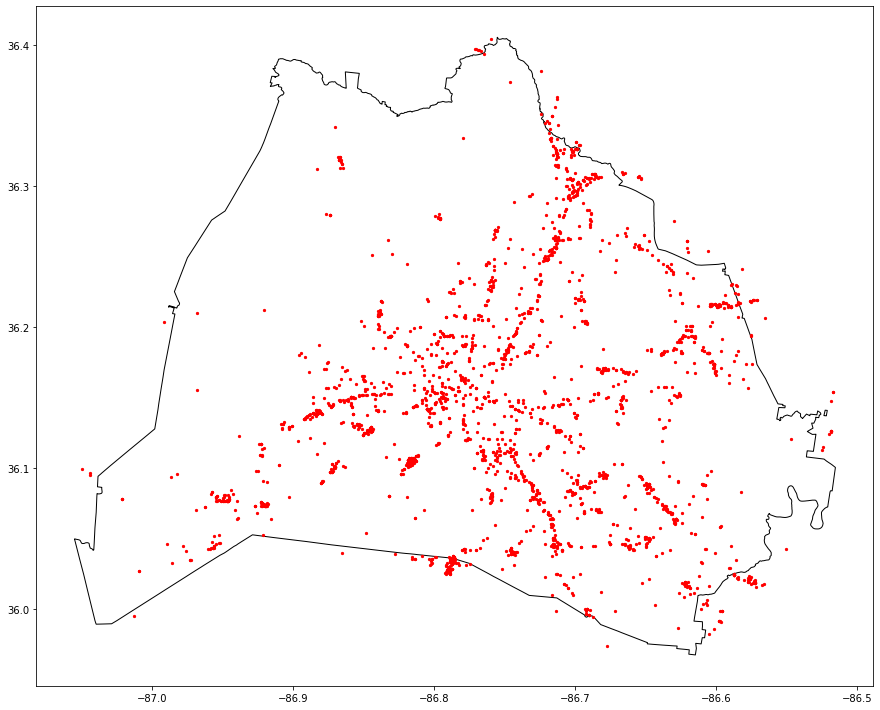

In [86]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_county.plot(color='white', edgecolor='black', ax = ax)
davidson_store_gdf.plot(ax=ax, marker='o', color='red', markersize=5);

# From the USDA website:  

#### The area of a food desert is definied by the census tract

https://www.ers.usda.gov/data-products/food-access-research-atlas/documentation/
"Most measures and definitions take into account at least some of the following indicators of access:

- Accessibility to sources of healthy food, as measured by distance to a store or by the number of stores in an area.
- Individual-level resources that may affect accessibility, such as family income or vehicle availability.
- Neighborhood-level indicators of resources, such as the average income of the neighborhood and the availability of public transportation."  

"This program defines a low-income census tract as any tract where:

- The tract’s poverty rate is 20 percent or greater; or
- The tract’s median family income is less than or equal to 80 percent of the State-wide median family income; or
- The tract is in a metropolitan area and has a median family income less than or equal to 80 percent of the metropolitan area's median family income."  

"Three measures of food access based on distance to a supermarket are provided in the Atlas:

- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than ½ mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 10 miles for a rural area. Using this measure, an estimated 54.4 million people, or 17.7 percent of the U.S. population, live in tracts that are low-income and low access and are more than ½ mile or 10 miles from the nearest supermarket.
- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than 1.0 mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 10 miles for a rural area. This measure shows that an estimated 19 million people, or 6.2 percent of the U.S. population, live in low-income and low access tracts and are more than 1 mile or 10 miles from a supermarket.
- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than 1.0 mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 20 miles for a rural area. Under this measure, an estimated 17.3 million people, or 5.6 percent of the U.S. population, live in low-income and low access tracts and are more than 1 mile or 20 miles from a supermarket."

#### Read in census tract shape file and narrow down to Davidson County

In [43]:
tennessee_tracts = gpd.read_file('data/cb_2018_47_tract_500k/cb_2018_47_tract_500k.shx')
tennessee_tracts.crs = "EPSG:4326"

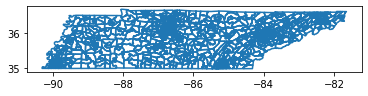

In [44]:
tennessee_tracts.boundary.plot()

Select only Davidson County tracts (COUNTYFP == 037)

In [45]:
davidson_tracts = tennessee_tracts[tennessee_tracts['COUNTYFP']=='037'].reset_index(drop = True)

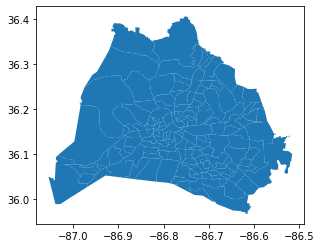

In [46]:
davidson_tracts.plot()

One of the criteria for food deserts is if at least 33% of the tract is more than 1 mile from a grocery store (there are different measures of how far from grocery store, like the above quote from the USDA. For the purposes of this analysis, use 1 mile away).

To show this on a map, include a `buffer` around store locations

In [87]:
davidson_store_buffers = gpd.GeoDataFrame(geometry = davidson_store_gdf['geometry'].buffer(0.014492753623188406),
                                          crs = "EPSG:4326")

''

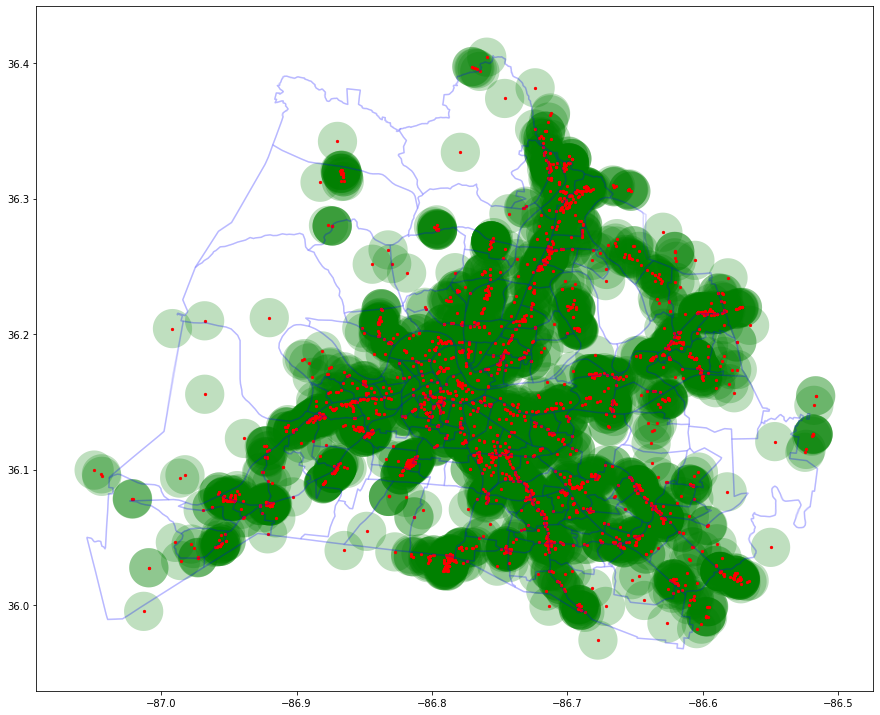

In [88]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.boundary.plot(ax=ax, edgecolor = 'blue', color='blue', alpha = 0.15)
ax = davidson_county.boundary.plot(ax=ax, color='blue', alpha = 0.15)
ax = davidson_store_buffers.plot(ax=ax, color = 'green', alpha = 0.25)
davidson_store_gdf.plot(ax=ax, marker='o', color='red', markersize=5)
;

## Determine if >= 33% of tract is > 1 mile away from store

Combine all store buffers

In [89]:
all_store_buffers = davidson_store_buffers.unary_union

# NOTE: Obviously cast too wide a net as not all these stores sell fresh produce. Wide net was intentional but need way to separate stores where fresh produce is sold from rest

In [90]:
for ind, row in davidson_tracts.iterrows():
    pct_near_store = row['geometry'].intersection(all_store_buffers).area/row['geometry'].area
    if pct_near_store <=0.333333333333:
        print(row['GEOID'], ':', pct_near_store)

47037010103 : 0.17115842009661872
47037013100 : 0.1844982291557819
47037010104 : 0.26304144798588597


## Now we can get poverty levels from the census projections

In [52]:
# from https://censusreporter.org/data/table/?table=B17001&geo_ids=14000US47037016000,05000US47037,04000US47,01000US,140|05000US47037&primary_geo_id=14000US47037016000
poverty_rates_davidson = pd.read_csv('data/acs2018_5yr_B17001_14000US47037011800/acs2018_5yr_B17001_14000US47037011800.csv')


In [54]:
# remove aggregation rows
poverty_rates_davidson_tract = poverty_rates_davidson.drop([0, 1, 2])

Column names stored in the metadata. import and add

In [55]:
with open('data/acs2018_5yr_B17001_14000US47037011800/metadata.json') as f:
    column_names = json.load(f)

In [56]:
column_names = {k: v['name'] for k, v in column_names['tables']['B17001']['columns'].items()}

In [57]:
poverty_rates_davidson_tract = poverty_rates_davidson_tract.rename(columns = column_names)

Calculate percent below poverty level

In [58]:
poverty_rates_davidson_tract['pct_below_poverty_level'] = poverty_rates_davidson_tract['Income in the past 12 months below poverty level:']/poverty_rates_davidson_tract['Total:']


Extract tract name for merging with tracts gdf

In [59]:
poverty_rates_davidson_tract['NAME'] = poverty_rates_davidson_tract['name'].str.split(' ').str[2].str[:-1]

In [60]:
davidson_tracts = davidson_tracts.merge(poverty_rates_davidson_tract[['NAME', 'pct_below_poverty_level']], how = 'left', on = 'NAME')
davidson_tracts['pct_below_poverty_level'] = davidson_tracts['pct_below_poverty_level'].fillna(np.median(davidson_tracts['pct_below_poverty_level']))

Make binary column of poverty level cutoff

In [61]:
davidson_tracts['above_20_pct'] = (davidson_tracts['pct_below_poverty_level'] > 0.2).astype(int)

''

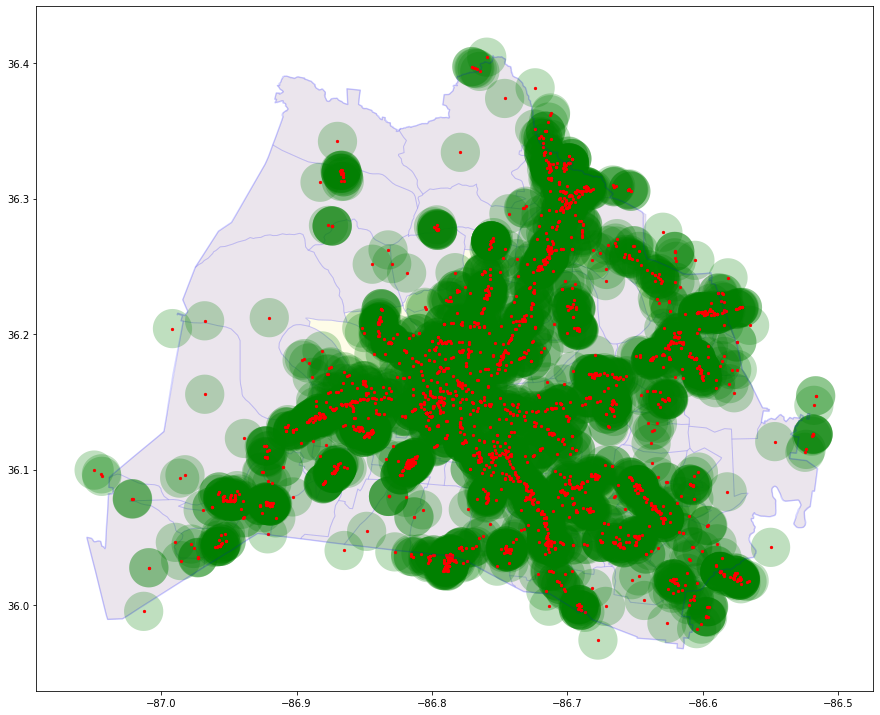

In [91]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'above_20_pct', edgecolor = 'blue', alpha = 0.1)
ax = davidson_county.boundary.plot(ax=ax, color='blue', alpha = 0.15)
ax = davidson_store_buffers.plot(ax=ax, color = 'green', alpha = 0.25)
davidson_store_gdf.plot(ax=ax, marker='o', color='red', markersize=5)
;

In [92]:
pd.DataFrame(responses_flat).to_csv('data/google_api_stores_responses_6-13-20.csv')

---

In [ ]:
# intentional error to interrupt Run All
int('a')

compare with previously published low food access data

In [ ]:
sheet_2 = pd.read_excel('DataDownload2015.xlsx', sheet_name = 2)

In [ ]:
for c in sheet_2.columns:
    print(c)

In [ ]:
sheet_2[(sheet_2['State'] == 'Tennessee') &
        (sheet_2['County']=='Davidson') & (sheet_2['CensusTract']==47037015625)]

In [ ]:
sheet_2['CensusTract'] = sheet_2['CensusTract'].astype(str)

In [ ]:
davidson_tracts_expand = pd.merge(davidson_tracts, sheet_2, how = "left", left_on = "GEOID", right_on = "CensusTract")

In [ ]:
study_fd = davidson_tracts_expand[davidson_tracts_expand['LILATracts_1And10'] == 1]['GEOID'].tolist()

In [ ]:
calc_fd = [47037015625,
47037010502,
47037013000,
47037010601,
47037018407,
47037015619,
47037010103,
47037010202,
47037019115,
47037013100,
47037018302,
47037018404,
47037018602,
47037015610,
47037010602,
47037015631,
47037018301,
47037018601,
47037010104,
47037018905,
47037019114,
47037015622,
47037018700,
47037010105,]

In [ ]:
list(set(study_fd)&set(calc_fd))

In [ ]:
pd.read_csv('mydata.csv')